In [111]:
# Gym stuff
import gym
import gym_anytrading
from gym_anytrading.envs import StocksEnv

# Stable baselines - rl stuff
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C
from stable_baselines3.common.sb2_compat.rmsprop_tf_like import RMSpropTFLike

# Processing libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

#Quant Finance
import yfinance as yf
from finta import TA


In [99]:
data = yf.Ticker("RELIANCE.NS").history(period="5y")
data.drop(columns=['Dividends','Stock Splits'], inplace=True)

# finta expects columns to be named: open, high, low, close, volume
data = data.rename(columns={
    "Open": "open",
    "High": "high",
    "Low": "low",
    "Close": "close",
    "Volume": "volume"
})

data['return'] = np.log(data['close'] / data['close'].shift(1))

#Create columns for technical indicators & add them to the dataframe
data['RSI'] = TA.RSI(data,16)
data['SMA'] = TA.SMA(data, 20)
data['SMA_L'] = TA.SMA(data, 41)
data['OBV'] = TA.OBV(data)
data['VWAP'] = TA.VWAP(data)
data['EMA'] = TA.EMA(data)
data['ATR'] = TA.ATR(data)
data.fillna(0, inplace=True)
data['momentum'] = data['return'].rolling(5).mean().shift(1)
data['volatility'] = data['return'].rolling(20).std().shift(1)
data['distance'] = (data['close'] - data['close'].rolling(50).mean()).shift(1)
data.tail()


,open,high,low,close,volume,return,RSI,SMA,SMA_L,OBV,VWAP,EMA,ATR,momentum,volatility,distance
Date,,,,,,,,,,,,,,,,
2025-05-26 00:00:00+05:30,1432.000000,1441.000000,1425.099976,1434.800049,4842944,0.005591,61.699400,1419.425006,1335.471945,1.584172e+09,1105.668723,1426.191001,27.557155,-0.004107,0.018603,110.193052
2025-05-27 00:00:00+05:30,1426.099976,1437.000000,1413.900024,1422.099976,12640414,-0.008891,58.696371,1422.090002,1338.398774,1.571531e+09,1105.855583,1425.372796,27.657148,-0.000835,0.018558,114.493052
2025-05-28 00:00:00+05:30,1420.099976,1422.599976,1410.699951,1412.900024,5944611,-0.006490,56.568896,1422.750006,1341.507312,1.565587e+09,1105.940923,1422.878242,26.878575,-0.000351,0.015228,98.118979
2025-05-29 00:00:00+05:30,1412.099976,1420.000000,1408.599976,1417.800049,13771917,0.003462,57.445177,1423.390009,1345.037800,1.579359e+09,1106.138491,1421.862603,25.371434,-0.002294,0.014542,85.607029
2025-05-30 00:00:00+05:30,1418.000000,1430.599976,1413.400024,1418.500000,2773898,0.000494,57.575601,1423.325006,1348.459753,1.582132e+09,1106.178944,1421.190082,22.185713,0.001188,0.014539,87.292053


In [101]:
#Perform a simple linear regression direction prediction
lags = 5

cols = []
for lag in range(1, lags + 1):
  col = f'lag_{lag}'
  data[col] = data['close'].shift(lag)
  cols.append(col)

data.dropna(inplace=True)

reg = np.linalg.lstsq(data[cols], data['close'], rcond=None)[0]
data['predicted_close'] = np.dot(data[cols], reg)
data.tail()

,open,high,low,close,volume,return,RSI,SMA,SMA_L,OBV,...,ATR,momentum,volatility,distance,lag_1,lag_2,lag_3,lag_4,lag_5,predicted_close
Date,,,,,,,,,,,,,,,,,,,,,
2025-05-26 00:00:00+05:30,1432.000000,1441.000000,1425.099976,1434.800049,4842944,0.005591,61.699400,1419.425006,1335.471945,1.584172e+09,...,27.557155,-0.004107,0.018603,110.193052,1426.800049,1409.400024,1429.199951,1424.599976,1440.800049,1426.965042
2025-05-27 00:00:00+05:30,1426.099976,1437.000000,1413.900024,1422.099976,12640414,-0.008891,58.696371,1422.090002,1338.398774,1.571531e+09,...,27.657148,-0.000835,0.018558,114.493052,1434.800049,1426.800049,1409.400024,1429.199951,1424.599976,1436.761541
2025-05-28 00:00:00+05:30,1420.099976,1422.599976,1410.699951,1412.900024,5944611,-0.006490,56.568896,1422.750006,1341.507312,1.565587e+09,...,26.878575,-0.000351,0.015228,98.118979,1422.099976,1434.800049,1426.800049,1409.400024,1429.199951,1421.288341
2025-05-29 00:00:00+05:30,1412.099976,1420.000000,1408.599976,1417.800049,13771917,0.003462,57.445177,1423.390009,1345.037800,1.579359e+09,...,25.371434,-0.002294,0.014542,85.607029,1412.900024,1422.099976,1434.800049,1426.800049,1409.400024,1412.280124
2025-05-30 00:00:00+05:30,1418.000000,1430.599976,1413.400024,1418.500000,2773898,0.000494,57.575601,1423.325006,1348.459753,1.582132e+09,...,22.185713,0.001188,0.014539,87.292053,1417.800049,1412.900024,1422.099976,1434.800049,1426.800049,1418.914586


In [102]:
class MyCustomEnv(StocksEnv):

#Create a function to properly format data frame to be passed through environment
    def _process_data(self):
        start = self.frame_bound[0] - self.window_size
        end = self.frame_bound[1]
        prices = self.df.loc[:,'close'].to_numpy()[start:end]
        signal_features = self.df.loc[:, ['open','high','low','volume','return','momentum','volatility','distance','RSI','OBV','SMA','SMA_L','VWAP','EMA','ATR', 'predicted_close']].to_numpy()[start:end]
        return prices, signal_features

#Initialize an environment setting the window size and train data
window_size = 63
start_index = window_size
end_train_index = round(len(data)*0.80)
end_val_index = len(data)

temp_env = MyCustomEnv(df=data, window_size=window_size, frame_bound=(start_index, end_train_index))
env_maker = lambda: temp_env
env = DummyVecEnv([env_maker])

#initialize our model and train
policy_kwargs = dict(optimizer_class=RMSpropTFLike, optimizer_kwargs=dict(eps=1e-5))
actor_critic = A2C('MlpPolicy', env, policy_kwargs=policy_kwargs, verbose=1)
actor_critic.learn(total_timesteps=10000)

Using cpu device
------------------------------------
| time/                 |          |
|    fps                | 467      |
|    iterations         | 100      |
|    time_elapsed       | 1        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.693   |
|    explained_variance | -0.00528 |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -7.17    |
|    value_loss         | 175      |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 538      |
|    iterations         | 200      |
|    time_elapsed       | 1        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -0.693   |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 199      |
|    policy_loss        | 10.9     |
|    value_loss      

In [103]:
#Create a new environment with validation data
env = MyCustomEnv(df=data, window_size=window_size, frame_bound=(end_train_index, end_val_index))
print("Frame bound:", env.frame_bound)
print("Window size:", env.window_size)
obs, _ = env.reset()
print("Initial observation shape:", obs.shape)

step = 0
while True:
    obs = obs[np.newaxis, ...]
    action, _states = actor_critic.predict(obs)
    obs, rewards, terminated, truncated, info = env.step(action)
    print(f"Step {step}, Reward: {rewards}, Done: {terminated or truncated}")
    step += 1
    done = terminated or truncated
    if done:
        print("info", info)
        break

Frame bound: (948, 1185)
Window size: 63
Initial observation shape: (63, 16)
Step 0, Reward: 0, Done: False
Step 1, Reward: 0, Done: False
Step 2, Reward: -4.4500732421875, Done: False
Step 3, Reward: 0, Done: False
Step 4, Reward: 0, Done: False
Step 5, Reward: 72.550048828125, Done: False
Step 6, Reward: 0, Done: False
Step 7, Reward: 0, Done: False
Step 8, Reward: 0, Done: False
Step 9, Reward: 34.625, Done: False
Step 10, Reward: 0, Done: False
Step 11, Reward: 0, Done: False
Step 12, Reward: 34.5999755859375, Done: False
Step 13, Reward: 0, Done: False
Step 14, Reward: -10.625, Done: False
Step 15, Reward: 0, Done: False
Step 16, Reward: 0, Done: False
Step 17, Reward: 0, Done: False
Step 18, Reward: 0, Done: False
Step 19, Reward: 0, Done: False
Step 20, Reward: -10.0499267578125, Done: False
Step 21, Reward: 0, Done: False
Step 22, Reward: -54.4749755859375, Done: False
Step 23, Reward: 0, Done: False
Step 24, Reward: 0, Done: False
Step 25, Reward: 0, Done: False
Step 26, Rewar

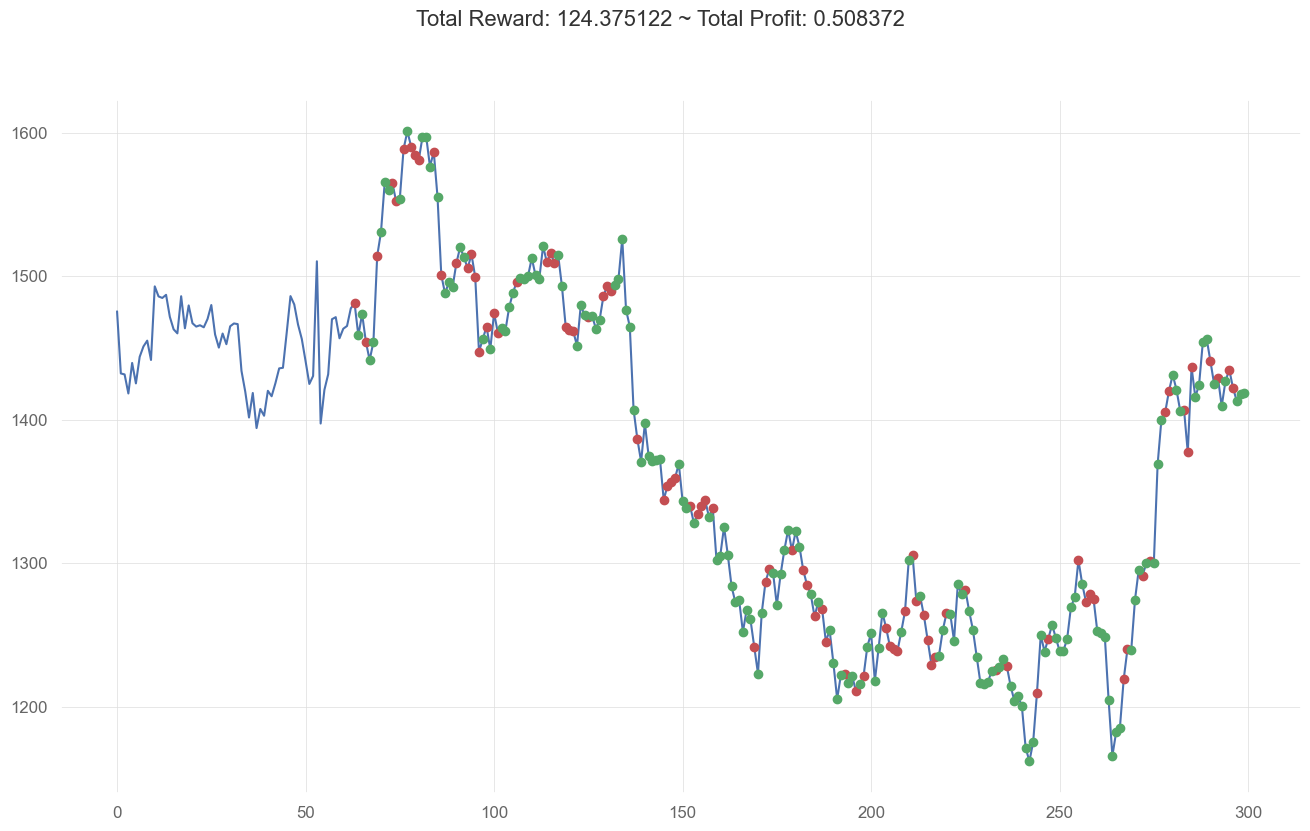

In [104]:
#Plot the results
plt.figure(figsize=(16,9))
env.render_all()
plt.show()